In [1]:
%cd ~/TOA_causal

/home/jovyan/TOA_causal


In [2]:
import torch
import os
from tqdm import tqdm
import numpy as np
from TOA.mbfdunetln import MBPFDUNet
from ANDMask.adam_flexible_weight_decay import AdamFlexibleWeightDecay
from torch.optim.lr_scheduler import MultiStepLR
from TOA.train import createForwMat
from utils.causal_utils import train,validation,testing,computing_metrics,load_traindataset,load_testdataset,load_ckp
from utils.noncausal_utils import load_traindataset_nc,train_nc

In [3]:
#batchsize = 2 #per environment
val_percent = 440.0/2216.0 # 440 para validacion, 1776 para train
le = 5
epochs = 50
#lr = 1e-3
#wd= 1e-6
#agreement_threshold = 0.5 
cache_dir = '../data/'
fecha = '280722_16'
continue_training = False

In [4]:
if torch.cuda.is_available():
	device = torch.device("cuda")
else:
	device = torch.device("cpu")
print(f"Device to be used: {device}")


##Loss
loss_fn = torch.nn.MSELoss()

##TOA matrix
Ao = createForwMat()
Ao = torch.as_tensor(Ao).type(torch.float32)
Ao = Ao.to(device=device)

##Files
ckp_last = cache_dir + 'mbfdunetln' + fecha + '.pth' # name of the file of the saved weights of the trained net
ckp_best = cache_dir + 'mbfdunetln_best' + fecha + '.pth'

#if continue_training:
#	model, optimizer, epoch0, valid_loss_min = load_ckp(ckp_last, model, optimizer)
#    lr_scheduler = MultiStepLR(optimizer,milestones=[le * epochs * 3 // 4],gamma=0.1,last_epoch = epoch0 - 1)
#else:
	#epoch0 = 0
	#valid_loss_min = np.inf

  8%|▊         | 1250/16384 [00:00<00:01, 12498.79it/s]

Device to be used: cuda
Creating Forward Model-based Matrix without position uncertainty
Creating SIR Matrix...


100%|██████████| 16384/16384 [00:01<00:00, 12688.69it/s]


Creating PA Matrix...
Applying Time Derivative Operator...
done
done


In [5]:
alphas = [1e-4,1e-3,1e-2]
wcosts = [0,1e-6]
bs = [2,3]
taus = [0.4,0.8]

checkpoint = {'valid_loss_min': np.inf}

epoch0 = 0
for batchsize in bs:
    train_loaders, val_loader = load_traindataset(cache_dir,val_percent,batchsize,val_batchsize=40,le = le)
    for wd in wcosts:
        for lr in alphas:
            for agreement_threshold in taus:
                model = MBPFDUNet().to(device=device)
                checkpoint['state_dict'] = model.state_dict()
                optimizer = AdamFlexibleWeightDecay(model.parameters(),lr=lr,weight_decay_order='before',weight_decay=wd)
                checkpoint['learning_rate'] = lr
                checkpoint['weight_cost'] = wd
                checkpoint['batchsize'] = batchsize
                checkpoint['agreement_threshold'] = agreement_threshold
                checkpoint['optimizer'] = optimizer.state_dict()
                checkpoint['epoch'] = epoch0
                lr_scheduler = MultiStepLR(optimizer,milestones=[le * epochs * 3 // 4],gamma=0.1)
                for epoch in tqdm(range(epoch0 + 1, epochs + 1)):
                    train(model,device,train_loaders,optimizer,n_agreement_envs=le,Ao=Ao,loss_fn=loss_fn,agreement_threshold=agreement_threshold,scheduler=lr_scheduler)
                    checkpoint['epoch'] = epoch
                    checkpoint['valid_loss_min'] = validation(model, device, val_loader, optimizer, loss_fn, Ao, checkpoint, ckp_last, ckp_best)

100%|██████████| 50/50 [1:55:19<00:00, 138.39s/it]


In [6]:
model, optimizer, best_epoch, valid_loss_min, best_lr, best_wd, best_bs, best_threshold = load_ckp(ckp_best, model, optimizer)

In [7]:
#from importlib import reload 
#import utils.noncausal_utils 
#reload(utils.noncausal_utils)
#from utils.noncausal_utils import train_nc

In [9]:
alphas = [1e-4,1e-3,1e-2]
wcosts = [0,1e-6]
bs = [2,3]
ckp_benchmark_last = cache_dir + 'benchmark' + fecha + '.pth'
ckp_benchmark_best = cache_dir + 'benchmark_best' + fecha + '.pth'
checkpoint_nc = {'valid_loss_min': np.inf, 'agreement_threshold' : 0.0}
epoch0 = 0
for batchsize in bs:
    train_loader_nc, val_loader_nc = load_traindataset_nc(cache_dir,val_percent,batchsize*le,val_batchsize=40,le = le)
    for lr in alphas:
        for wd in wcosts:
            model_nc = MBPFDUNet().to(device=device)
            checkpoint_nc['state_dict'] = model_nc.state_dict()
            optimizer_nc = torch.optim.Adam(model_nc.parameters(),lr=lr,weight_decay=wd)
            checkpoint_nc['learning_rate'] = lr
            checkpoint_nc['weight_cost'] = wd
            checkpoint_nc['batchsize'] = batchsize
            checkpoint_nc['optimizer'] = optimizer_nc.state_dict()
            checkpoint_nc['epoch'] = epoch0
            lr_scheduler_nc = MultiStepLR(optimizer_nc,milestones=[le * epochs * 3 // 4],gamma=0.1)
            for epoch in tqdm(range(epoch0 + 1, epochs + 1)):
                train_nc(model_nc,device,train_loader_nc,optimizer_nc,Ao=Ao,loss_fn=loss_fn,scheduler=lr_scheduler_nc)
                checkpoint_nc['epoch'] = epoch
                checkpoint_nc['valid_loss_min'] = validation(model_nc, device, val_loader_nc, optimizer_nc, loss_fn, Ao, checkpoint_nc, ckp_benchmark_last, ckp_benchmark_best)

100%|██████████| 50/50 [35:19<00:00, 42.38s/it]


In [13]:
#ckp_benchmark_last = cache_dir + 'benchmark' + fecha + '.pth'
#ckp_benchmark_best = cache_dir + 'benchmark_best' + fecha + '.pth'
#model_nc = MBPFDUNet().to(device=device)
#optimizer_nc = torch.optim.Adam(model_nc.parameters(),lr=lr,weight_decay=wd)
#lr_scheduler_nc = MultiStepLR(optimizer,milestones=[le * epochs * 3 // 4],gamma=0.1)
#if continue_training:
#    model_nc, optimizer_nc, epoch0, vlm_nc = load_ckp(ckp_benchmark_last, model_nc, optimizer_nc)
#else:
#    epoch0 = 0
#    vlm_nc = np.inf
#train_loader_nc, val_loader_nc = load_traindataset_nc(cache_dir,val_percent,batchsize*le,val_batchsize=40,le = le)
#for epoch in tqdm(range(epoch0 + 1, epochs + 1)):
#    train_nc(model_nc,device,train_loader_nc,optimizer_nc,Ao=Ao,loss_fn=loss_fn,scheduler=lr_scheduler_nc)
#    vlm_nc = validation(model_nc, device, val_loader_nc, optimizer_nc, loss_fn, Ao, vlm_nc, epoch, ckp_benchmark_last, ckp_benchmark_best)

model_nc, optimizer_nc, best_epoch_nc, vlm_nc, lr_nc, wd_nc, bs_nc, at_nc= load_ckp(ckp_benchmark_best, model_nc, optimizer_nc)

In [14]:
test_loaders = load_testdataset(cache_dir)
le_test = len(test_loaders)
SSIM = [[] for _ in range(le_test)] 
PC = [[] for _ in range(le_test)] 
RMSE = [[] for _ in range(le_test)]
PSNR = [[] for _ in range(le_test)]
for j in range(le_test):
    iterator = iter(test_loaders[j])
    while 1:
        try:
            data_test = next(iterator)
        except StopIteration:
            break  
        a,b,c,d=computing_metrics(data_test[0].to("cpu"),data_test[1].to("cpu"),Ao.to(device="cpu"),model,model_nc)
        SSIM[j].append(a)
        PC[j].append(b)
        RMSE[j].append(c)
        PSNR[j].append(d)


 Environment 0 

############################################################### 

Metrics results NET (ANDMask): 
 SSIM:  0.592  PC:  0.834  RMSE:  0.117  PSNR:  18.929
Metrics results NET (benchmark): 
 SSIM:  0.574  PC:  0.832  RMSE:  0.121  PSNR:  18.689
Metrics results LBP: 
 SSIM:  0.05  PC:  0.235  RMSE:  0.438  PSNR:  7.526
Metrics results DAS: 
 SSIM:  -0.058  PC:  0.609  RMSE:  0.452  PSNR:  7.476


############################################################### 


 Environment 1 

############################################################### 

Metrics results NET (ANDMask): 
 SSIM:  0.878  PC:  0.976  RMSE:  0.047  PSNR:  27.181
Metrics results NET (benchmark): 
 SSIM:  0.838  PC:  0.963  RMSE:  0.06  PSNR:  25.113
Metrics results LBP: 
 SSIM:  0.132  PC:  0.631  RMSE:  0.372  PSNR:  9.151
Metrics results DAS: 
 SSIM:  -0.23  PC:  0.373  RMSE:  0.616  PSNR:  4.859


############################################################### 



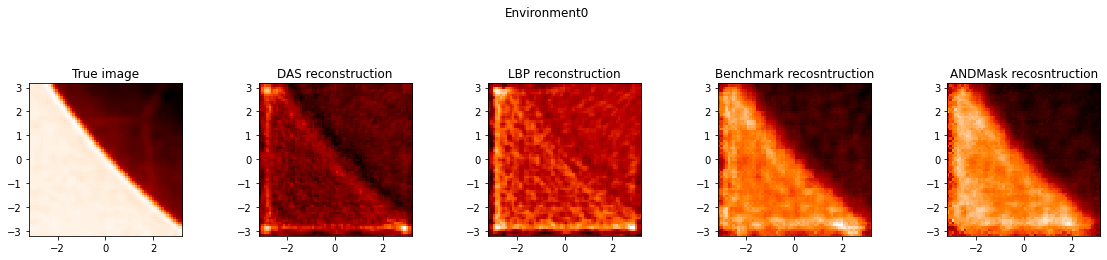

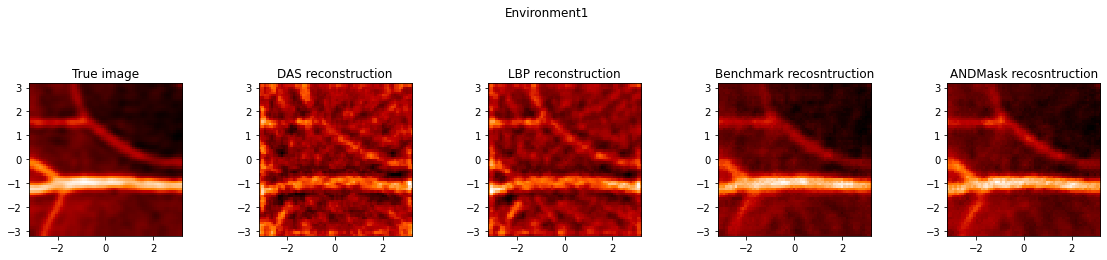

In [16]:
#from importlib import reload 
#import utils.causal_utils 
#reload(utils.causal_utils)
#from utils.causal_utils import testing
testing(np.array(SSIM),np.array(PC),np.array(RMSE),np.array(PSNR),test_loaders, Ao.to(device="cpu"),model, model_nc)